## Fine Tuning 

In [1]:
import re
import os
import json
import openai
import pickle
from testing import Tester
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [2]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

c:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 500 examples (and 1 epoch)

fine_tune_train = train[:500]
fine_tune_validation = train[500:550]

### Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [4]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [5]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [6]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [7]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [9]:
# with open("fine_tune_train.jsonl", "rb") as f:
#     train_file = openai.files.create(file=f, purpose="fine-tune")

with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.File.create(file=f, purpose="fine-tune")


In [10]:
train_file

<File file id=file-KjGn3FQY7tP49jXWy9aruD at 0x22dd9acad50> JSON: {
  "object": "file",
  "id": "file-KjGn3FQY7tP49jXWy9aruD",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 470870,
  "created_at": 1741828057,
  "expires_at": null,
  "status": "processed",
  "status_details": null
}

In [11]:
# with open("fine_tune_validation.jsonl", "rb") as f:
#     validation_file = openai.files.create(file=f, purpose="fine-tune")

with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.File.create(file=f, purpose="fine-tune")


In [12]:
validation_file

<File file id=file-A7ohXCzdN42VShRf3dTvAw at 0x22dd1a3f170> JSON: {
  "object": "file",
  "id": "file-A7ohXCzdN42VShRf3dTvAw",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 47108,
  "created_at": 1741828110,
  "expires_at": null,
  "status": "processed",
  "status_details": null
}

## Step 2

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

### And now time to Fine-tune!

In [18]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [ ]:

response = openai.FineTuningJob.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    hyperparameters={"n_epochs": 1},
    seed=42,
    integrations = [wandb_integration],
    suffix="price"
)

print(response)



{
  "object": "fine_tuning.job",
  "id": "ftjob-HAjEp8pbqs5lQiubcYlAGSzZ",
  "model": "gpt-4o-mini-2024-07-18",
  "created_at": 1741829214,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-Poi94RVaWbMRqwqJHJNz04c1",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-A7ohXCzdN42VShRf3dTvAw",
  "training_file": "file-KjGn3FQY7tP49jXWy9aruD",
  "hyperparameters": {
    "n_epochs": 1,
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": "price",
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "gpt-pricer",
        "entity": null,
        "run_id": "ftjob-HAjEp8pbqs5lQiubcYlAGSzZ"
      }
    }
  ],
  "metadata": null,
  "method": {
    "type": "supervised",
    "supervised": {
      "hyperparameters": {
        "batch_size": "auto",
        "learning_rate_multiplier": "aut

In [ ]:
openai.FineTuningJob.list(limit=1)

<OpenAIObject list at 0x22dd9ae73b0> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job",
      "id": "ftjob-HAjEp8pbqs5lQiubcYlAGSzZ",
      "model": "gpt-4o-mini-2024-07-18",
      "created_at": 1741829214,
      "finished_at": null,
      "fine_tuned_model": null,
      "organization_id": "org-Poi94RVaWbMRqwqJHJNz04c1",
      "result_files": [],
      "status": "validating_files",
      "validation_file": "file-A7ohXCzdN42VShRf3dTvAw",
      "training_file": "file-KjGn3FQY7tP49jXWy9aruD",
      "hyperparameters": {
        "n_epochs": 1,
        "batch_size": 1,
        "learning_rate_multiplier": 1.8
      },
      "trained_tokens": null,
      "error": {},
      "user_provided_suffix": "price",
      "seed": 42,
      "estimated_finish": null,
      "integrations": [
        {
          "type": "wandb",
          "wandb": {
            "project": "gpt-pricer",
            "entity": null,
            "run_id": "ftjob-HAjEp8pbqs5lQiubcYlAGSzZ"
          }

In [29]:
job_id = openai.FineTuningJob.list(limit=1).data[0].id

In [30]:
job_id

'ftjob-HAjEp8pbqs5lQiubcYlAGSzZ'

In [33]:
openai.FineTuningJob.retrieve(job_id)

<FineTuningJob fine_tuning.job id=ftjob-HAjEp8pbqs5lQiubcYlAGSzZ at 0x22dd9aca810> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-HAjEp8pbqs5lQiubcYlAGSzZ",
  "model": "gpt-4o-mini-2024-07-18",
  "created_at": 1741829214,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-Poi94RVaWbMRqwqJHJNz04c1",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-A7ohXCzdN42VShRf3dTvAw",
  "training_file": "file-KjGn3FQY7tP49jXWy9aruD",
  "hyperparameters": {
    "n_epochs": 1,
    "batch_size": 1,
    "learning_rate_multiplier": 1.8
  },
  "trained_tokens": null,
  "error": {},
  "user_provided_suffix": "price",
  "seed": 42,
  "estimated_finish": null,
  "integrations": [
    {
      "type": "wandb",
      "wandb": {
        "project": "gpt-pricer",
        "entity": null,
        "run_id": "ftjob-HAjEp8pbqs5lQiubcYlAGSzZ"
      }
    }
  ],
  "metadata": null,
  "method": {
    "type": "supervised",
    "supervised": {
      "hyperpara

In [36]:
# openai.FineTuningJob.list_events(fine_tuning_job_id=job_id, limit=10).data
response = openai.FineTuningJob.list_events(id=job_id, limit=10)

In [38]:
# events = response.data  # This contains the actual events
# for event in events:
#     print(event)

## Step 3

Test our fine tuned model

In [51]:
fine_tuned_model_name = openai.FineTuningJob.retrieve(job_id).fine_tuned_model

In [52]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:price:BAS3lXKe'

In [40]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [41]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [42]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [53]:
def gpt_fine_tuned(item):
    response = openai.ChatCompletion.create(
        model=fine_tuned_model_name,  # Ensure this is defined
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    
    reply = response["choices"][0]["message"]["content"]
    return get_price(reply)


In [47]:
print(test[0].price)

374.41


In [54]:
print(gpt_fine_tuned(test[0]))

174.77


1: Guess: $174.77 Truth: $374.41 Error: $199.64 SLE: 0.58 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $118.47 Truth: $225.11 Error: $106.64 SLE: 0.41 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $219.98 Truth: $599.99 Error: $380.01 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.98 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.99 Truth: $65.99 Error: $62.00 SLE: 0.43

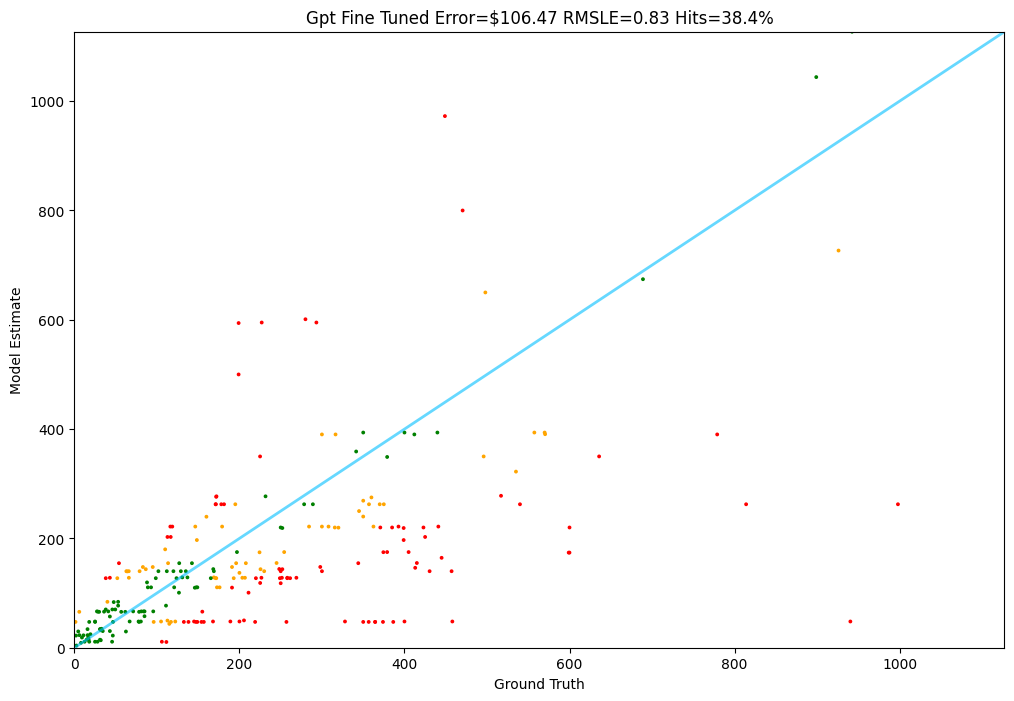

In [56]:
Tester.test(gpt_fine_tuned, test)